# Analysis - Subject 24

In [1]:
import numpy as np
import matplotlib
import mne
from mne.io.reference import set_eeg_reference
#from mne.time_frequency import psd_welch
mne.set_log_level('error')

subject = 'aalis-24'

event_id = {'Sound_Trigger':1, 'Unlabelled/Standard':3, 'Unlabelled/Oddball':4, 'Beep_Start':6, 'Experience_Sample':7, 
            'MW1/Standard':11, 'MW2/Standard':12, 'MW3/Standard':13, 'MW4/Standard':14, 'MW5/Standard':15,
            'MW1/Oddball':21, 'MW2/Oddball':22, 'MW3/Oddball':23, 'MW4/Oddball':24, 'MW5/Oddball':25
           }

event_mappings = {'1':1, '3':3, '4':4, '6':6, '7':7}

cond_of_interest = sorted(event_id.keys())

# specify the time window for epoching
tmin = -0.2  # start of each epoch (in sec)
tmax =  1.0  # end of each epoch (in sec)

# './' specifies that data are in the same directory as this notebook
data_path = './eeg_recordings/' 

# Input should be continuous EEG data in EEGLAB format, named as [subject].set
raw_fname = data_path + subject + '.set' #raw_fname = data_path + subject + '.vhdr'

# We have EOG but we didn't use them.
eog_inds = ["HEOG", "VEOG"]

# Filter cutoffs and other parameters
l_freq = 0.1
h_freq = 40.0
l_trans_bandwidth = 'auto'
h_trans_bandwidth = 'auto'
filter_length='auto'

# maximum number of ICs to reject in ICA artifact correction
ica_random_state = 42  # seed so ICA is reproducable each time it's run
n_max_ecg = 3
n_max_eog = 3
# Specify n_components as a decimal to set % explained variance
n_components = .99

#################################################################
# It's unlikely you will want to change any settings below here

baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(eeg=200e-6, eog=200e-6)  # EEG data are in V, so e-6 gives microVolts

# standard montage file to look up channel locations
montage_fname = 'standard_1020' #1005

# output file names - set to follow MNE conventions
epochs_fname  = data_path + subject + '-epo.fif'
evoked_fname = data_path + subject + '-ave.fif'

## Import data

In [2]:
raw = mne.io.read_raw_eeglab(raw_fname, 
                          eog=eog_inds, 
                          montage=montage_fname,
                          preload=True) 

%matplotlib inline

## Filtering

### First plot frequency spectrum prior to filtering, for later comparison

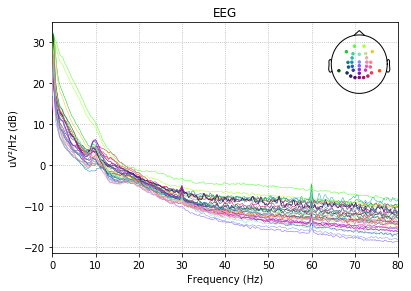

In [3]:
raw.plot_psd(fmax=80, average=False, spatial_colors=True, line_alpha=1, n_jobs=8);

### Now bandpass filter, then plot filtered data

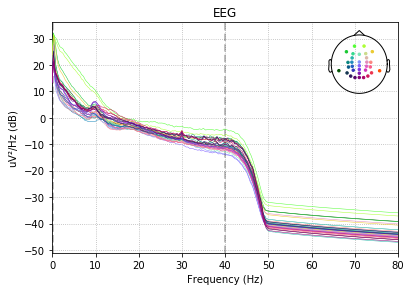

In [4]:
raw.filter(l_freq, h_freq, 
           l_trans_bandwidth = l_trans_bandwidth, 
           h_trans_bandwidth = h_trans_bandwidth, 
           filter_length=filter_length, 
           method='fft', 
           n_jobs = 1)  

raw.plot_psd(fmax=80, average=False, spatial_colors=True, line_alpha=1, n_jobs=1);

## Interactive plot of continuous data - identify and mark bad channels
Scroll through the plot to identify channels for exclusion from analysis. In this case the channels more-or-less look good, but with lots of blinks.


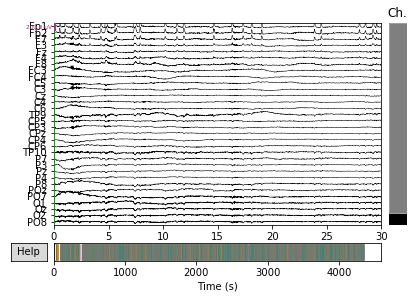

In [5]:
%matplotlib inline
raw.plot(n_channels=32, scalings=dict(eeg=.0001), duration=30, title='Raw EEG'); 

No bads this time. Lots of messy things, but channels ain't one of them.

In [6]:
raw.info['bads'] = [] #none!

# Event Processing
Event codes are stored in a 'channel' called STI 014. We will be creating some manually labelled codes, calculated from the MW response time

## Start by fixing the sound trigger delay problem

In [5]:
event_mappings = {'1':1, '3':3, '4':4, '6':6, '7':7}

In [6]:
events, event_dict = mne.events_from_annotations(raw, event_id=event_mappings)

In [7]:
cleaned_events = []

for event in events:
    if event[2] == 3 or event[2] == 4:
        for e in events:
            if e[0] > event[0] and e[0] < (event[0]+200) and e[2] == 1: #find the nearest audio signal within 200 ms
                event[0] = e[0]
                cleaned_events.append(event)
    elif event[2] == 6 or event[2] == 7:
        cleaned_events.append(event)

events = np.array(cleaned_events)

### Calculate the manually pressed signals from raw that were generated by button activation

In [8]:
quiz_signals = []

for event in events:
    if event[2] == 7:
        quiz_signals.append(event)

print(len(quiz_signals)) #number of mind wandering prompts

10


### Label the event signals based on PsychoPy responses
This script opens the PsychoPy file and creates an array of the probe responses, sequentially.

In [9]:
import csv
wandering_labels = []

with open('psychopy_data/24_eLearn-new_2018_Nov_02_1442.csv') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        if row[6] == "a":
            wandering_labels.append("MW1") # completely on task
        elif row[6] == "b":
            wandering_labels.append("MW2")
        elif row[6] == "c":
            wandering_labels.append("MW3")
        elif row[6] == "d":
            wandering_labels.append("MW4")
        elif row[6] == "e":
            wandering_labels.append("MW5") # completely mind wandering

print(wandering_labels)

['MW3', 'MW2', 'MW2', 'MW1', 'MW4', 'MW2', 'MW2', 'MW2', 'MW2', 'MW2']


### Generate the list of events to have the signals changed, and change the signals 

In [10]:
events_backup = events.copy()

In [11]:
event_id = {'Sound_Trigger':1, 'Unlabelled/Standard':3, 'Unlabelled/Oddball':4, 'Beep_Start':6, 'Experience_Sample':7, 
            'MW1/Standard':11, 'MW2/Standard':12, 'MW3/Standard':13, 'MW4/Standard':14, 'MW5/Standard':15,
            'MW1/Oddball':21, 'MW2/Oddball':22, 'MW3/Oddball':23, 'MW4/Oddball':24, 'MW5/Oddball':25
           }

In [12]:
for event in events:
    for i in range(0,10):
         if event[0] < (quiz_signals[i][0]) and event[0] > (quiz_signals[i][0]-10000):
                if wandering_labels[i] == 'MW1':
                    if event[2] == 3:
                        event[2] = 11
                    elif event[2] == 4:
                        event[2] = 21
                        
                if wandering_labels[i] == 'MW2':
                    if event[2] == 3:
                        event[2] = 12
                    elif event[2] == 4:
                        event[2] = 22

                if wandering_labels[i] == 'MW3':
                    if event[2] == 3:
                        event[2] = 13
                    elif event[2] == 4:
                        event[2] = 23

                if wandering_labels[i] == 'MW4':
                    if event[2] == 3:
                        event[2] = 14
                    elif event[2] == 4:
                        event[2] = 24

                if wandering_labels[i] == 'MW5':
                    if event[2] == 3:
                        event[2] = 15
                    elif event[2] == 4:
                        event[2] = 25

## Remove absent codes from event_id dict
For associating codes with labels in `viz.plot_events`, we can only have entries in the dict for codes actually in the data

In [13]:
actual_codes = [i for i in list(event_id.values()) if i in np.unique(events[:,2])]

event_id_actual = {}

for k in event_id.keys():
    if event_id[k] in actual_codes:
        event_id_actual[k] =  event_id[k]
        
event_id = event_id_actual

### A plot to visualize the new event times

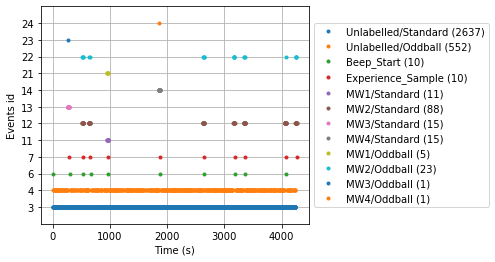

In [14]:
%matplotlib inline
fig = mne.viz.plot_events(events, raw.info['sfreq'], event_id=event_id);

## Epoching

In [15]:
picks_eeg = mne.pick_types(raw.info, eeg=True, eog=True,
                           stim=False, exclude=[]) 

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False, 
                    picks=picks_eeg, baseline=baseline, detrend=1, preload=True, event_repeated='drop', 
                    reject = dict(eeg=1e-3, # V (EEG channels)
                                  eog=1e-3 # V (EOG channels)
                                  )              
                   )

print(epochs) # gives us number of trials per condition prior to artrej

<Epochs  |   3326 events (all good), -0.199219 - 1 sec, baseline [None, 0], ~530.7 MB, data loaded,
 'Beep_Start': 8
 'Experience_Sample': 10
 'MW1/Oddball': 5
 'MW1/Standard': 11
 'MW2/Oddball': 23
 'MW2/Standard': 88
 'MW3/Oddball': 1
 'MW3/Standard': 15
 'MW4/Oddball': 1
 'MW4/Standard': 14
 'Unlabelled/Oddball': 546
 'Unlabelled/Standard': 2604>


### Plot average of all epochs
You should see big artifacts in the data, since we haven't done artifact correction yet. 

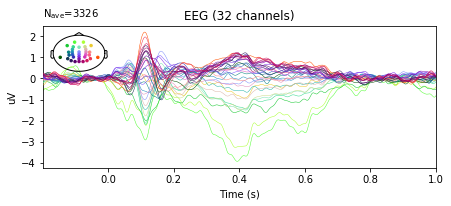

In [18]:
%matplotlib inline
epochs.average().plot(spatial_colors=True);

# Run ICA to identify and correct ocular artifacts

In [19]:
n_components = .99

ica = mne.preprocessing.ICA(n_components=n_components, method='fastica', 
                            max_iter=500, random_state=ica_random_state)

picks = mne.pick_types(epochs.info, meg=False, 
                       eeg=True, eog=False, stim=False, exclude='bads')

ica.fit(epochs, picks=picks, decim=3, reject=None)

<ICA  |  epochs decomposition, fit (fastica): 681830 samples, 16 components, channels used: "eeg">

### Plot scalp maps of each Independent Component
Ocular artifact components should load heavily over the front of the head and little/not at all elsewhere.

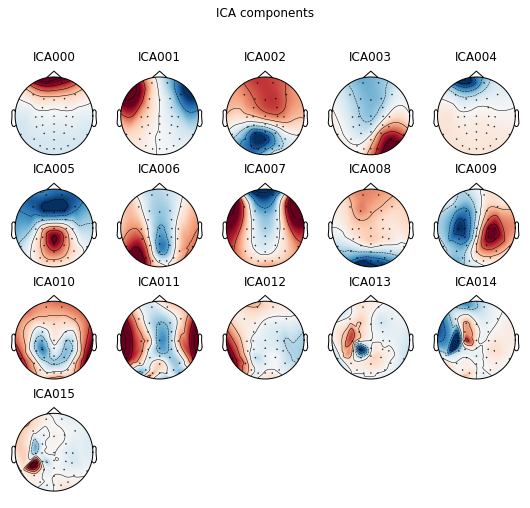

In [20]:
%matplotlib inline
ica.plot_components(picks=None, ch_type='eeg');

### Plot individual components and do manual artifact selection

My criteria for rejection are:
1. Obvious ocular artifact (blinks weigh heavily on anterior channels, all same polarity; horizontal movements weight heavily on either side of the eyes, with opposite polarity on each side)
- Raster plots show that component weights heavily on a very low number of trials, and little/not at all on most trials
- "Epochs variance" is high on a low number of trials, and generally low on most trials
- Topo plot shows a very focal effect around a single electrode, with very little/no weighting at most other electrodes (keeping in mind that the topo plots are interpolated so there will be some "smearing" of an effect even at a single electrode) 
- No apparent correlation between average waveform (shown in bottom of raster plot) and an IC with a clear, strong, sensory ERP (i.e., no suggestion of part or all of a P1-N-P2 complex)

Need to manually change the "picks" number for each plot based on visual inspection of the topo plots of the components, above.

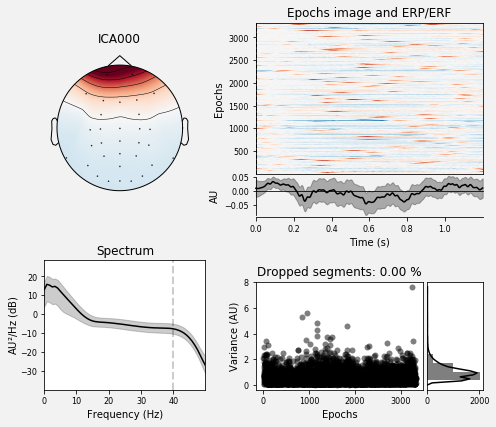

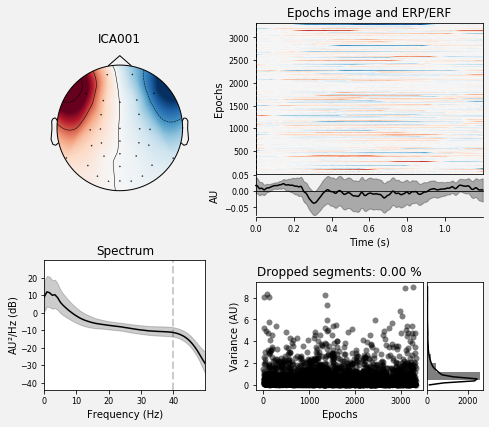

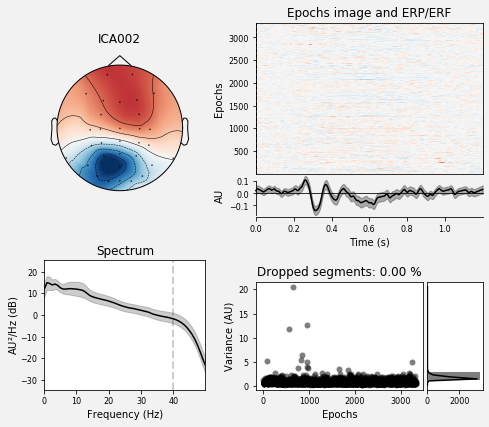

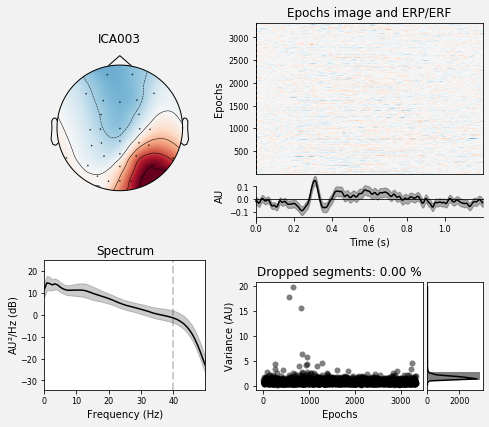

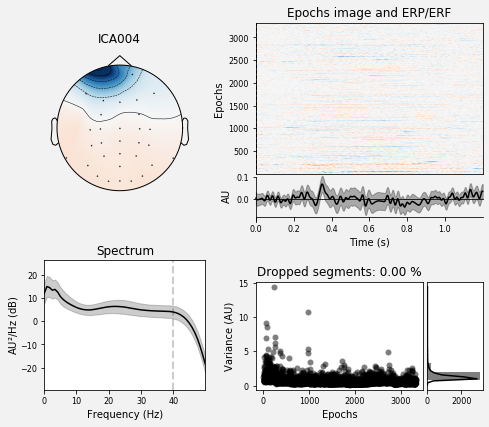

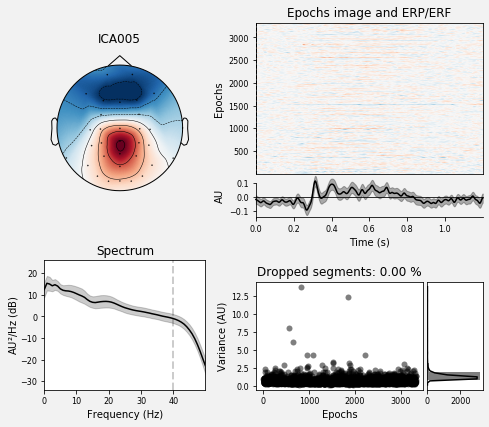

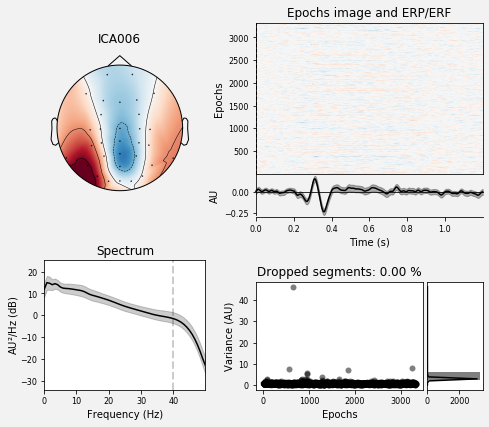

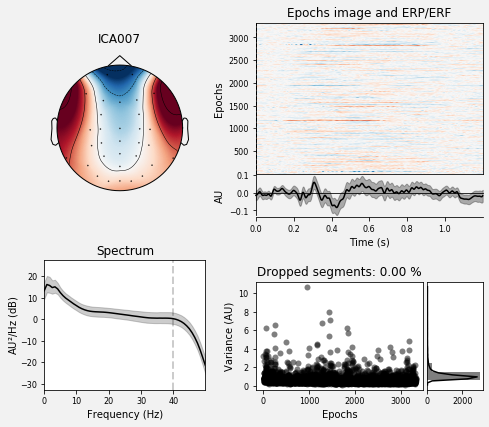

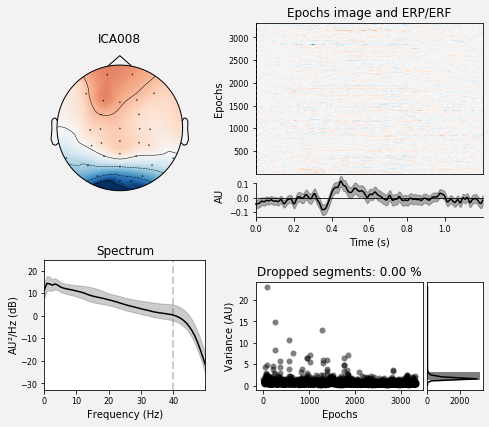

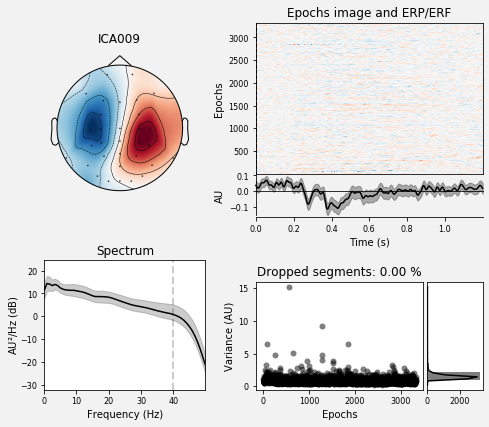

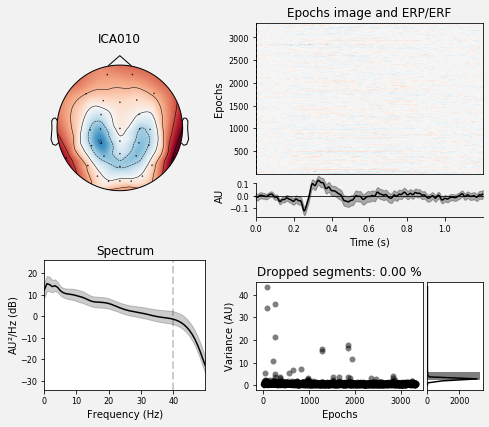

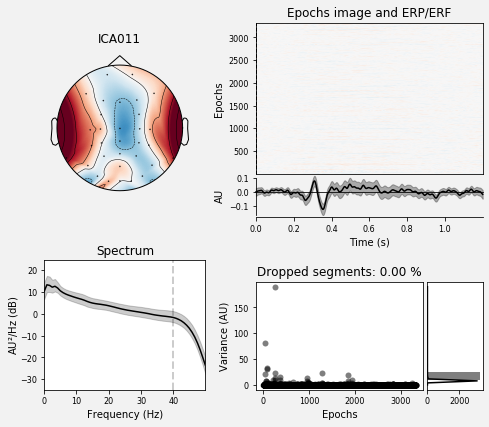

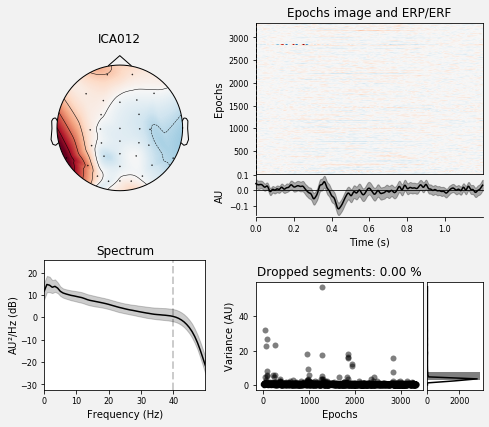

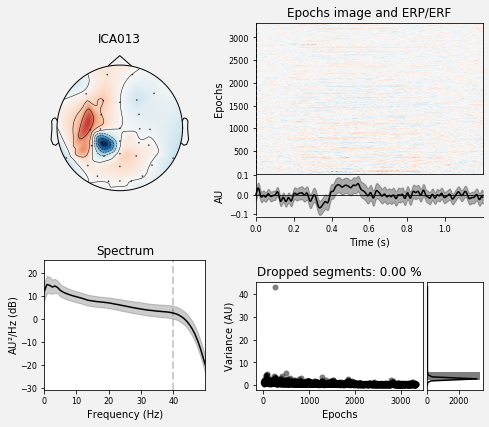

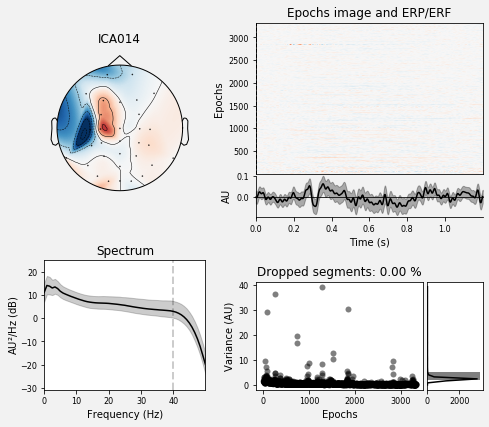

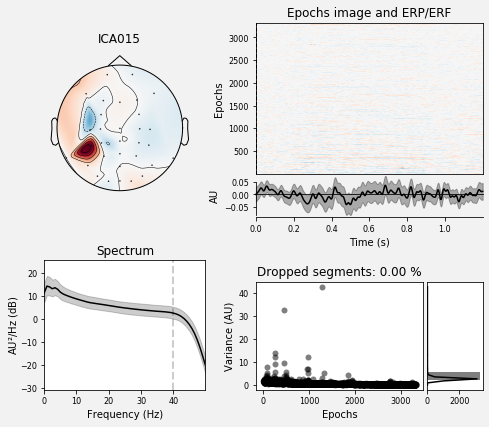

In [21]:
ica.plot_properties(epochs, picks=range(0,ica.n_components_));

### Manually specify ICs to remove, based on visual inspection
The automatic process doesn't remove as many ICs as necessary for EEG

In [22]:
ica.exclude = [0,1,6,11,12,13,14,15]

# Apply ICA corrections to data, and re-reference to average mastoids

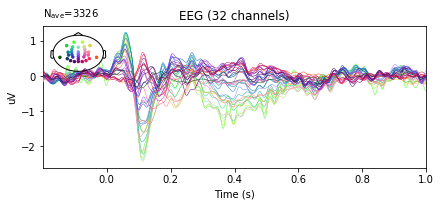

Overwriting existing file.


In [23]:
epochs_postica = ica.apply(epochs.copy()).apply_baseline(baseline)
epochs_postica_mstd = set_eeg_reference(epochs_postica, ref_channels=['TP9','TP10'])[0]
epochs_postica_mstd.interpolate_bads()
epochs_postica_mstd.average().plot(spatial_colors=True);
epochs_postica_mstd.save(epochs_fname, overwrite=True)

# Create Evoked Responses (averaged epochs for each condition)
This will save a file of the evoked data as well, which you will load in later, in a different script, for group data analysis).

In [24]:
evokeds = {cond:epochs_postica_mstd[cond].average() for cond in event_id.keys()}
mne.write_evokeds(evoked_fname, list(evokeds.values()))

In [25]:
evokeds

{'Unlabelled/Standard': <Evoked  |  'Unlabelled/Standard' (average, N=2604), [-0.19922, 1] sec, 32 ch, ~244 kB>,
 'Unlabelled/Oddball': <Evoked  |  'Unlabelled/Oddball' (average, N=546), [-0.19922, 1] sec, 32 ch, ~244 kB>,
 'Beep_Start': <Evoked  |  'Beep_Start' (average, N=8), [-0.19922, 1] sec, 32 ch, ~244 kB>,
 'Experience_Sample': <Evoked  |  'Experience_Sample' (average, N=10), [-0.19922, 1] sec, 32 ch, ~244 kB>,
 'MW1/Standard': <Evoked  |  'MW1/Standard' (average, N=11), [-0.19922, 1] sec, 32 ch, ~244 kB>,
 'MW2/Standard': <Evoked  |  'MW2/Standard' (average, N=88), [-0.19922, 1] sec, 32 ch, ~244 kB>,
 'MW3/Standard': <Evoked  |  'MW3/Standard' (average, N=15), [-0.19922, 1] sec, 32 ch, ~244 kB>,
 'MW4/Standard': <Evoked  |  'MW4/Standard' (average, N=14), [-0.19922, 1] sec, 32 ch, ~244 kB>,
 'MW1/Oddball': <Evoked  |  'MW1/Oddball' (average, N=5), [-0.19922, 1] sec, 32 ch, ~244 kB>,
 'MW2/Oddball': <Evoked  |  'MW2/Oddball' (average, N=23), [-0.19922, 1] sec, 32 ch, ~244 kB>,
 